In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from tqdm import tqdm
import time
import random

from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Show figures
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", palette="deep")
# darkgrid, whitegrid, dark, white, ticks
# deep, muted, bright, pastel, dark, colorblind

# Parsing
from selenium import webdriver
import myutils
# import geocoder   -- для быстрой проверки

import re
import json

import folium

import os
import glob

# import importlib
# myutils = importlib.reload(myutils)

In [2]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

from sklearn.metrics import make_scorer
rmse_score = make_scorer(rmse, greater_is_better=False)

In [3]:
train = pd.read_csv('./data/train_test/train.csv', index_col=0)
test = pd.read_csv('./data/train_test/test.csv', index_col=0)

train['isTrain'] = True
test['isTrain'] = False

In [4]:
X = train.append(test, sort=False)

In [ ]:
X.describe().T

In [ ]:
X.describe(include='object').T

### Сохраняем/загружаем чищенные данные

In [4]:
# X.to_csv('./data/X_clean.csv')
X = pd.DataFrame.from_csv('./data/X_clean.csv')

/home/ivan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


# Train-,Test- выборки

In [13]:
drop_cols = ['target', 'isTrain', 'address', 'address_rus', 'address_translit', 'inplace_cats', 'city',
             'lat_1', 'long_1', 'count_latlong', 'cat_', 'stops_count', 'dist_to_stop',
             'indexes_1', 
             'distance_2',
             'indexes_2', 'var_2', 'distance_3', 'indexes_3', 'var_3', 'distance_4',
             'indexes_4', 'var_4', 'distance_5', 'indexes_5', 'var_5']

X_ = X[X.isTrain].drop(drop_cols, axis=1)
Y_ = X.loc[X.isTrain, 'target']
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.2, random_state=1)

In [14]:
X_train.info(max_cols=2000)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5008 entries, 2161 to 5157
Data columns (total 1080 columns):
id                                                              5008 non-null float64
atm_group                                                       5008 non-null float64
lat                                                             5008 non-null float64
long                                                            5008 non-null float64
count                                                           5008 non-null float64
city_lab                                                        5008 non-null int64
rare_city                                                       5008 non-null float64
bankomat_city_count                                             5008 non-null int64
cat_СУПЕРМАРКЕТ                                                 5008 non-null float64
cat_АПТЕКА                                                      5008 non-null float64
cat_БАНКОМАТ                    

#### Если надо убрать категории

In [253]:
X_ = X[X.isTrain].drop(drop_cols, axis=1)
filter_col = [col for col in X_ if col.startswith('cat_')]
for col in filter_col:
    X_.drop(col, axis=1, inplace=True)
    
Y_ = X.loc[X.isTrain, 'target']
X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.2, random_state=1)

In [15]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253 entries, 5734 to 6239
Columns: 1080 entries, id to median
dtypes: float64(1078), int64(2)
memory usage: 10.3 MB


#  Алгоритмы Оценки

In [16]:
gbm = lgb.LGBMRegressor(objective = 'regression',  
                            max_depth = 5,
                            colsample_bytre = 0.8,
                            subsample = 0.8, 
                            learning_rate = 0.1,
                            n_estimators = 300)

In [ ]:
gbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], eval_metric='rmse', early_stopping_rounds=7)

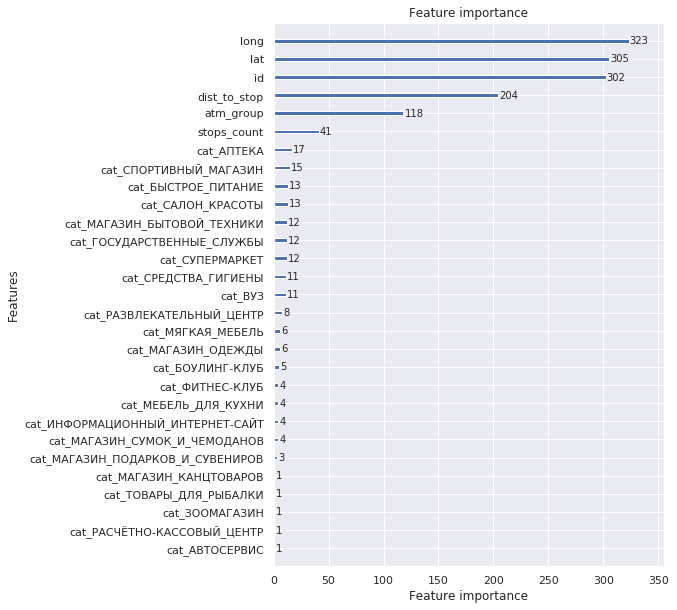

In [95]:
%matplotlib inline
lgb.plot_importance(gbm, max_num_features=40, figsize=(7,10))

In [96]:
rmse(Y_valid, gbm.predict(X_valid))

0.045971638126885817

In [412]:
param_grid = {'max_depth': [15, 20, 25],
              'n_estimators': [200, 250, 300],
#               'boosting_type':['gbdt', 'dart', 'goss']
#               'reg_alpha':[0, .4 ], # L1 regularization term on weights.
#               'reg_lambda':[0, .4 ] # L2 regularization term on weights.
             }

grid_gbm = model_selection.GridSearchCV(gbm,
                            param_grid=param_grid, 
                            cv=5, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_gbm.fit(X_, Y_, eval_metric='rmse', verbose=False)
rmse(Y_valid, grid_gbm.best_estimator_.predict(X_valid))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   18.0s finished


0.0286995542835094

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=25, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0) 0.0286995542835094


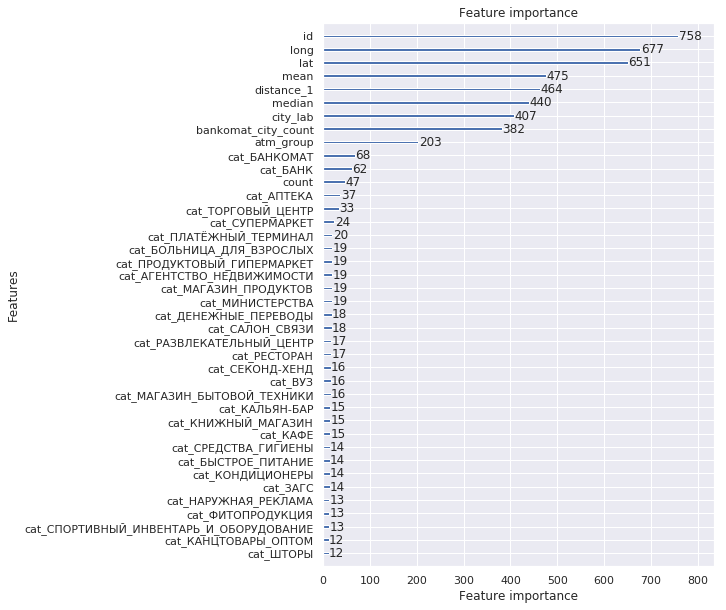

In [413]:
print(grid_gbm.best_estimator_, rmse(Y_valid, grid_gbm.best_estimator_.predict(X_valid)))
# lgb.plot_importance(grid_gbm.best_estimator_)
lgb.plot_importance(grid_gbm.best_estimator_, max_num_features=40, figsize=(7,10))

###  Выбираю самые полезные признаки

In [266]:
X_feat = X[X.columns[[np.argsort(-grid_gbm.best_estimator_.feature_importances_)[:500]]]].copy()

In [267]:
drop_cols = ['target', 'isTrain', 'address', 'address_rus', 
#              'address_translit',
             'inplace_cats', 'city',
             'count_latlong']

X_ = X_feat[X_feat.isTrain].drop(drop_cols, axis=1)
Y_ = X_feat.loc[X_feat.isTrain, 'target']

X_train, X_valid, Y_train, Y_valid = train_test_split(X_, Y_, test_size=0.2, random_state=1)

In [284]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5008 entries, 2161 to 5157
Columns: 493 entries, cat_СЛУЖБА СПАСЕНИЯ to cat_НЕРУДНЫЕ МАТЕРИАЛЫ
dtypes: float64(493)
memory usage: 18.9 MB


## Отправка сабмита

Отправка данных на данных с парсингом:

In [414]:
X_test = X[~X.isTrain].drop(drop_cols, axis=1)
submit = pd.DataFrame(grid_gbm.best_estimator_.predict(X_test), index=test.index,columns=['target'])
submit.to_csv('submit.csv')

#### Когда выбирал самые полезные признаки

In [100]:
X_test = X_feat[~X_feat.isTrain].drop(drop_cols, axis=1)
submit = pd.DataFrame(grid_gbm.best_estimator_.predict(X_test), index=test.index,columns=['target'])
submit.to_csv('submit.csv')

Мало признаков оказалось, на ЛБ 13 == 2019-01-09 17:49:02 == **0.045546**

хотя предыдущий с тысячей признаков был лучше 12 == 2019-01-09 17:14:17 == **0.044499**


чистка данных

16 == 2019-01-10 23:46:22 == **0.044026**

## LightGBM для каждого банка

14 2019-01-09 18:40:28 **0.167788**

In [104]:
X['atm_group'].unique()

array([  32. ,  496.5, 1022. , 1942. , 3185.5, 5478. , 8083. ])

### 8083

In [380]:
param_grid = {'max_depth': [5, 10, 15],
              'n_estimators': [50, 100, 150],
#               'boosting_type':['gbdt', 'dart', 'goss']
#               'reg_alpha':[0, .2, .4, .6 ], # L1 regularization term on weights.
#               'reg_lambda':[0, .2, .4, .6 ] # L2 regularization term on weights.
             }

grid_gbm_8083 = model_selection.GridSearchCV(gbm,
                            param_grid=param_grid, 
                            cv=5, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_gbm_8083.fit(X_[X_['atm_group']==8083], Y_[X_['atm_group']==8083], eval_metric='rmse', verbose=False)
rmse(Y_[X_['atm_group']==8083], grid_gbm_8083.best_estimator_.predict(X_[X_['atm_group']==8083]))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.4s finished


0.03445076077771145

In [381]:
grid_gbm_8083.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=5, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=50, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

###  non 8083

In [382]:
param_grid = {'max_depth': [5, 10, 15],
              'n_estimators': [50, 100, 150],
#               'boosting_type':['gbdt', 'dart', 'goss']
#               'reg_alpha':[0, .2, .4, .6 ], # L1 regularization term on weights.
#               'reg_lambda':[0, .2, .4, .6 ] # L2 regularization term on weights.
             }

grid_gbm_non_8083 = model_selection.GridSearchCV(gbm,
                            param_grid=param_grid, 
                            cv=5, scoring=rmse_score, verbose=1, n_jobs=-1)
grid_gbm_non_8083.fit(X_[X_['atm_group']!=8083], Y_[X_['atm_group']!=8083], eval_metric='rmse', verbose=False)
rmse(Y_[X_['atm_group']!=8083], grid_gbm_non_8083.best_estimator_.predict(X_[X_['atm_group']!=8083]))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   11.0s finished


0.03249306684955817

In [383]:
grid_gbm_non_8083.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytre=0.8,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
       max_depth=15, min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0)

### submit

In [384]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2504 entries, 6261 to 8764
Columns: 1082 entries, id to median
dtypes: float64(1080), int64(2)
memory usage: 20.7 MB


In [385]:
X_test = X[~X.isTrain].drop(drop_cols, axis=1)

submit_8083    = pd.DataFrame(grid_gbm.best_estimator_.predict(X_test[X_test['atm_group']==8083]), index=X_test[X_test['atm_group']==8083].index, columns=['target'])
submit_non8083 = pd.DataFrame(grid_gbm.best_estimator_.predict(X_test[X_test['atm_group']!=8083]), index=X_test[X_test['atm_group']!=8083].index, columns=['target'])

submit = pd.DataFrame(pd.concat([submit_8083, submit_non8083]).values, index=test.index,columns=['target'])
submit.to_csv('submit.csv')

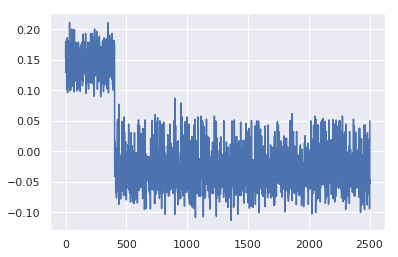

In [386]:
plt.plot(pd.concat([submit_8083, submit_non8083]).values)

# RandomForestRegressor

In [387]:
from sklearn import ensemble

In [ ]:
param_grid = {'max_depth': [5, 10],
#               'criterion' : ['gini', 'entropy'],
              'n_estimators': [20, 50], #np.arange(350, 500, 100),
#               'min_samples_leaf': [5, 10] 
             }

grid_rforest = model_selection.GridSearchCV(ensemble.RandomForestRegressor(criterion='mae', n_jobs=4),
                            param_grid=param_grid, 
                            cv=5, scoring=rmse_score, verbose=10, n_jobs=4)
grid_rforest.fit(X_train, Y_train)
grid_rforest.best_estimator_, grid_rforest.best_score_

In [ ]:
rmse(Y_valid, grid_rforest.best_estimator_.predict(X_valid))

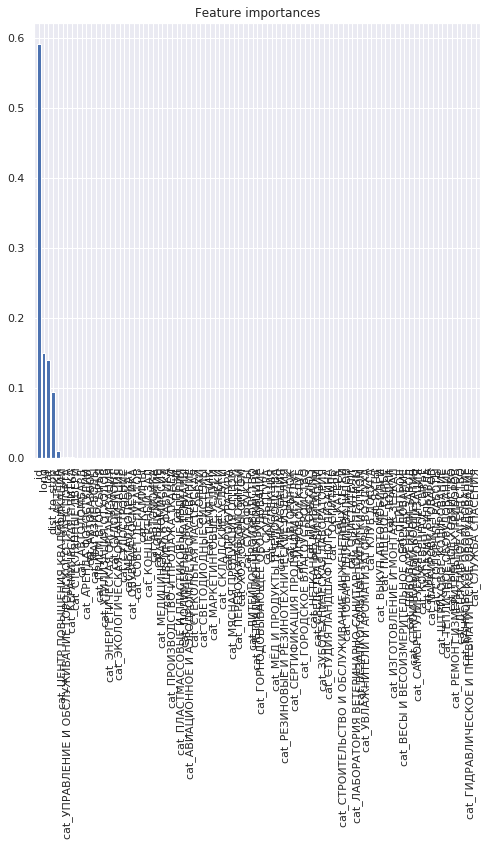

In [179]:
d_first = len(X_train.columns) / 3
feature_names = X_train.columns
importances = grid_rforest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

### Отправка сабмита 

In [ ]:
X_test = X[~X.isTrain][columns_data]
submit = pd.DataFrame(grid_rforest.best_estimator_.predict(X_test_na), index=X_test_na.index,columns=['target'])
submit_WithNa = pd.DataFrame(0.0, index=X_test_WithNan.index,columns=['target'])
submit = submit.append(submit_WithNa)
submit.sort_index(inplace=True)
submit.index = range(len(submit))
submit.to_csv('submit.csv')

# SVRegression

In [180]:
from sklearn import svm

In [245]:
param_grid = {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'] }
grid_svr = model_selection.GridSearchCV(svm.SVR(max_iter=40000, tol=0.00001), param_grid=param_grid, 
                 cv=5, scoring=rmse_score, verbose=10, n_jobs=-1)
grid_svr.fit(X_train, Y_train)
grid_svr.best_estimator_, grid_svr.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   30.0s remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   57.8s remaining:   47.3s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.2min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  1.3min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.4min finished
/home/ivan/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma='auto_deprecated', kernel='sigmoid', max_iter=50000,
   shrinking=True, tol=1e-05, verbose=False), -0.08733115360737387)

In [246]:
rmse(Y_valid, grid_svr.best_estimator_.predict(X_valid))

0.0853850164804536

# BayesianRidge

In [248]:
from sklearn.linear_model import BayesianRidge

In [269]:
param_grid = {'alpha_1' : [1.e-6, 1.e-3],
              'alpha_2' : [1.e-6, 1.e-3],
              'lambda_1' : [1.e-6,  1.e-3],
              'lambda_2' : [1.e-6, 1.e-3]}
bayridge = model_selection.GridSearchCV(BayesianRidge(n_iter=50), param_grid=param_grid, 
                 cv=5, scoring=rmse_score, verbose=10, n_jobs=-1)
bayridge.fit(X_train, Y_train)
bayridge.best_estimator_, bayridge.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:   35.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   36.3s finished


(BayesianRidge(alpha_1=0.001, alpha_2=1e-06, compute_score=False, copy_X=True,
        fit_intercept=True, lambda_1=1e-06, lambda_2=0.001, n_iter=50,
        normalize=False, tol=0.001, verbose=False), -0.06473441021078154)

In [270]:
rmse(Y_valid, bayridge.best_estimator_.predict(X_valid))

0.06446655244708625

# Decision Tree

In [271]:
from sklearn import tree

In [272]:
param_grid = {'max_depth': [10,20,40,60]      }
grid = model_selection.GridSearchCV(tree.DecisionTreeRegressor(criterion='mae'), 
                       param_grid=param_grid, 
                       scoring = rmse_score, 
                       cv=5,
                       verbose=10, n_jobs=-1)
# grid.fit(X_train, Y_train)
grid.fit(X_, Y_)
estDT = grid.best_estimator_
grid.best_score_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   21.6s remaining:   32.3s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   38.6s remaining:   31.5s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   41.3s remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   48.7s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   52.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   52.9s finished


-0.05092675465522596

In [280]:
grid.best_estimator_

DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [275]:
rmse(Y_valid, grid.best_estimator_.predict(X_valid))

0.04040265128709968

### boosting

In [276]:
%%time
estAB = ensemble.AdaBoostRegressor(estDT, n_estimators=10, random_state=13)
estAB.fit(X_train, Y_train)

CPU times: user 1min 9s, sys: 0 ns, total: 1min 9s
Wall time: 1min 9s


In [279]:
rmse(Y_valid, estAB.predict(X_valid))

0.04681478316433638

In [277]:
param_grid = {'n_estimators': [10, 15, 20],
              'max_depth' : [7, 10, 15]
#               'loss': ['linear', 'square']
             }
gridAB = model_selection.GridSearchCV( ensemble.AdaBoostRegressor(estDT, random_state=13), 
                       #param_distributions=param_grid, n_iter=2,
                       param_grid=param_grid, 
                       scoring = rmse_score, cv=3,
                       verbose=10, n_jobs=-1)
gridAB.fit(X_, Y_)
gridAB.best_score_, gridAB.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   37.3s remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   37.4s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.1min remaining:   54.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.4min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.9min remaining:   32.3s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.1min finished


-0.047172908726564794

In [282]:
# to delete
gridAB.best_estimator_


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=15,
         random_state=13)

In [278]:
rmse(Y_valid, gridAB.best_estimator_.predict(X_valid))

0.03429232302847872

#### submit

In [ ]:
X_test = X[~X.isTrain].drop(drop_cols, axis=1)
submit = pd.DataFrame(gridAB.best_estimator_.predict(X_test), index=test.index,columns=['target'])
submit.to_csv('submit.csv')

In [285]:
X_test = X_feat[~X_feat.isTrain].drop(drop_cols, axis=1)
submit = pd.DataFrame(gridAB.best_estimator_.predict(X_test), index=test.index,columns=['target'])
submit.to_csv('submit.csv')

rmse - test **0.03429232302847872**

15 -- 2019-01-10 14:25:22 -- **0.046682**

#### gradient

In [286]:
%%time
params = {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
estGB = ensemble.GradientBoostingRegressor(**params)
estGB.fit(X_train, Y_train)

CPU times: user 40.3 s, sys: 17.5 ms, total: 40.3 s
Wall time: 40.3 s


In [287]:
rmse(Y_valid, estGB.predict(X_valid))

0.04626995772788192

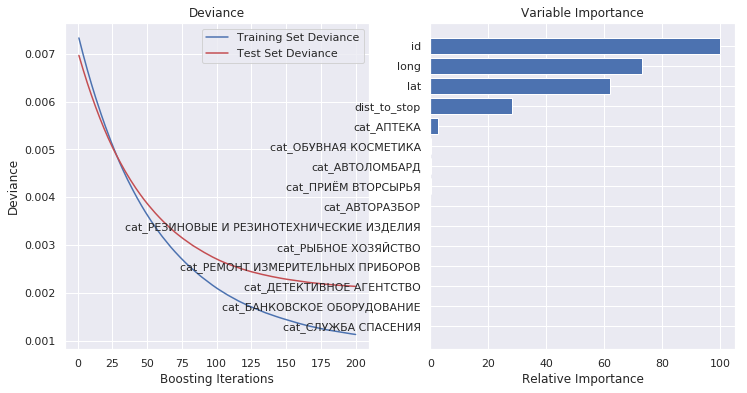

In [288]:
# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(estGB.staged_predict(X_valid)):
    test_score[i] = estGB.loss_(Y_valid, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, estGB.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = estGB.feature_importances_[:15]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### bagging

In [289]:
param_grid = {'n_estimators': [10, 15, 20],
              'max_samples' : [.2, .5, 1.0]
             }
grid_bag = model_selection.GridSearchCV( ensemble.BaggingRegressor(estDT, random_state=13, n_jobs=4), 
                       param_grid=param_grid, 
                       scoring = rmse_score, cv=3,
                       verbose=10, n_jobs=4)
grid_bag.fit(X_, Y_)
grid_bag.best_score_, grid_bag.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   38.6s
/home/ivan/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  23 out of  27 | elapsed:  1.5min remaining:   15.8s
[Parallel(n_jobs=4)]: Done  27 out of  27 | elapsed:  2.0min finished


(-0.04653612218002433,
 BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=10, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=1.0, n_estimators=20, n_jobs=4, oob_score=False,
          random_state=13, verbose=0, warm_start=False))

In [290]:
rmse(Y_valid, grid_bag.best_estimator_.predict(X_valid))

0.03785620813028242

#### submit

In [291]:
X_test = X_feat[~X_feat.isTrain].drop(drop_cols, axis=1)
submit = pd.DataFrame(grid_bag.best_estimator_.predict(X_test), index=test.index,columns=['target'])
submit.to_csv('submit.csv')

rmse - test **0.03785620813028242**

